In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor

import statsmodels.api as sm

# enviroment variable
visualize = False

model_linearRegression = False
model_randomForestRegressor = False
model_Ridge = False
model_CatBoostRegressor = False
model_XGBRegressor = False

In [2]:
train_data_path = 'train.csv'
test_data_path = 'test.csv'

df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

print("Train Dataset shape -->", df.shape)
print("Test Dataset shape -->", test_df.shape)

Train Dataset shape --> (5760, 15)
Test Dataset shape --> (3000, 14)


In [3]:
# df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

In [4]:
df.rename(columns={'Temperature(�C)':'Temperature','Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_speed',
                   'Dew point temperature(�C)':'Dew_point_temperature','Solar Radiation (MJ/m2)':'Solar_Radiation',
                   'Visibility (10m)':'Visibility','Functioning Day':'Functioning_Day', 'Rainfall(mm)':'Rainfall',
                   'Snowfall (cm)':'Snowfall'},inplace=True)

test_df.rename(columns={'Temperature(�C)':'Temperature','Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_speed',
                   'Dew point temperature(�C)':'Dew_point_temperature','Solar Radiation (MJ/m2)':'Solar_Radiation',
                   'Visibility (10m)':'Visibility','Functioning Day':'Functioning_Day', 'Rainfall(mm)':'Rainfall',
                   'Snowfall (cm)':'Snowfall'},inplace=True)

In [5]:
if visualize:
    # show the distrbution for each feature and the bikes count(y)
    df.hist(figsize=(15, 18))
    plt.show()
    test_df.hist(figsize=(15, 18))
    plt.show()
    numeric_column = df.columns[df.dtypes != 'object']
    print(numeric_column)
#     for numeric_column in numeric_columns:
#     plot_lmplot(x=numeric_column, y='y', data=train_df, hue='Holiday', col='Seasons', row='Functioning Day')

In [6]:
# Check for the outliers in all of the numerical columns
def outliers_check(df):
    num_columns= df.columns[df.dtypes != 'object']
    print('numerical columns number =', len(num_columns))
    cols_with_outliers = []
    for col in num_columns:
        sns.boxplot(y=df[col])
        plt.show()
        Q25, Q75 = np.percentile(df[col], [25, 75])
        IQR = Q75 - Q25
        upper_limit = Q75 + (1.5 * IQR)
        lower_limit = Q25 - (1.5 * IQR)
        number_of_outliers = ((df[col] > upper_limit)|(df[col] < lower_limit)).sum()
        print(col+'_col_min =', min(df[col]))
        print(col+'_col_max =', max(df[col]))
        print(col+'_col_Q25 =', Q25)
        print(col+'_col_Q75 =', Q75)
        print(col+'_col_IQR =', IQR)
        print(col+'_col_upper_limit =', upper_limit)
        print(col+'_col_lower_limit =', lower_limit)
        print(col+'_col_Number of Outliers based on IQR rule =', number_of_outliers)
        if number_of_outliers > 0:
            cols_with_outliers.append(col)
        print('----------------------------------------------------------------------')
    return cols_with_outliers
if visualize:
    cols_with_outliers = outliers_check(df)
    print('cols_with_outliers are :', cols_with_outliers)
    print('----------------------------------------------------------------------')    
    print('cols_with_outliers number :', len(cols_with_outliers))
    print('----------------------------------------------------------------------')    

In [7]:
# Extract the numeric features to be scatterd with bikes count
def scatter_numeric_features(data, features, target):
    for feature in features:
        sns.scatterplot(x=data[feature], y=data[target])
        plt.show()
    
numeric_features = ['Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 
                    'Solar_Radiation', 'Rainfall', 'Snowfall']
if visualize:
    scatter_numeric_features(df, numeric_features, 'y')

In [8]:
# Split the day into 4 quarters based on Bike rent count
def split_day(hour):
    if hour >= 23 or hour <= 5:
        return 'early_morning'
    elif hour >= 6 and hour <= 10:
        return 'morning'
    elif hour >= 11 and hour <= 17:
        return 'afternoon'
    else:
        return 'night'
df['DaySplitedBasedOnHour'] = df['Hour'].apply(split_day)
test_df['DaySplitedBasedOnHour'] = test_df['Hour'].apply(split_day)

# Extract the Categorical features to bar plot it against it's count
def plot_categorical_features(data, features, target):
    for feature in features:
        plt.bar(data[feature], data[target])
        plt.ylabel('y')
        plt.show()
        data[feature].value_counts().plot(kind='bar')
        plt.ylabel('Count')
        plt.show()
        plt.pie(data.groupby(feature, as_index=False).sum()[target], labels=data.groupby(feature, as_index=False).sum()[feature])
        plt.show()
        
categorical_features = ['Seasons', 'Holiday', 'Functioning_Day', 'Hour']
if visualize:
    plot_categorical_features(df, categorical_features, 'y')

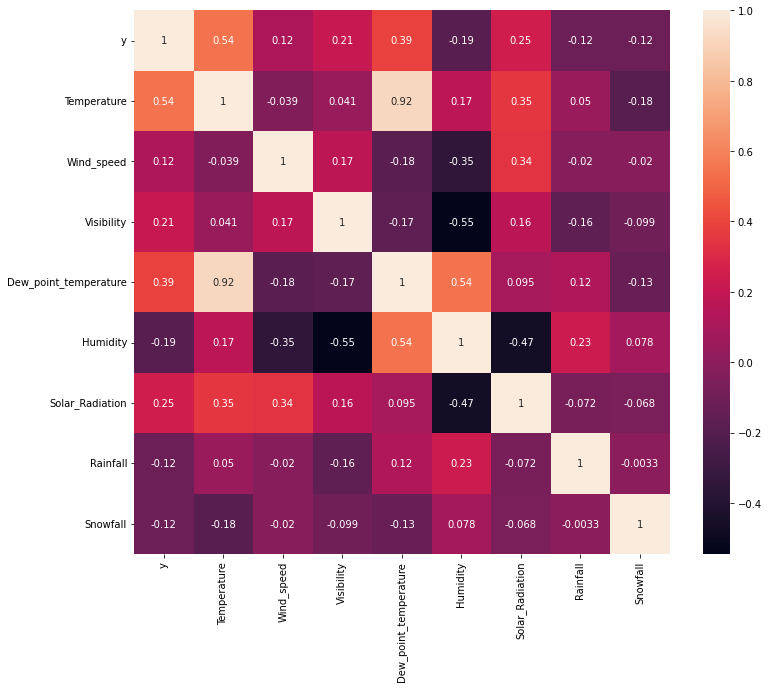

In [9]:
# correlation between the numeric features and bikes count
numeric_features_Target = ['y', 'Temperature', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Humidity',
                           'Solar_Radiation', 'Rainfall', 'Snowfall']
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_features_Target].corr(), annot=True)
plt.show()

In [10]:
# Correlation between Categorical features and bikes count using ANOVA
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(data, features, target):
    # Creating an empty list of final selected predictors
    Selectedfeatures=[]
    
    print('##### ANOVA Results ##### \n')
    for feature in features:
        CategoryGroupLists=data.groupby(feature)[target].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(feature, 'is correlated with', 'Bikes Count', '| P-Value:', AnovaResults[1])
            Selectedfeatures.append(feature)
        else:
            print(feature, 'is NOT correlated with', 'Bikes Count', '| P-Value:', AnovaResults[1])
    
    return(Selectedfeatures)

FunctionAnova(df, categorical_features, 'y')

##### ANOVA Results ##### 

Seasons is correlated with Bikes Count | P-Value: 5.24e-322
Holiday is correlated with Bikes Count | P-Value: 9.439100395022195e-06
Functioning_Day is correlated with Bikes Count | P-Value: 2.2657501351119632e-68
Hour is correlated with Bikes Count | P-Value: 0.0


['Seasons', 'Holiday', 'Functioning_Day', 'Hour']

In [11]:
# get day, month and weekday out of Date column and get sin and cos of each one
def encode_hour(data, test_data, col):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/24)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/24)
    test_data[col + '_sin'] = np.sin(2 * np.pi * test_data[col]/24)
    test_data[col + '_cos'] = np.cos(2 * np.pi * test_data[col]/24)
def encode_day(data, test_data, col):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/31)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/31)
    test_data[col + '_sin'] = np.sin(2 * np.pi * test_data[col]/31)
    test_data[col + '_cos'] = np.cos(2 * np.pi * test_data[col]/31)
def encode_month(data, test_data, col):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/12)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/12)
    test_data[col + '_sin'] = np.sin(2 * np.pi * test_data[col]/12)
    test_data[col + '_cos'] = np.cos(2 * np.pi * test_data[col]/12)
def encode_weekday(data, test_data, col):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/7)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/7)
    test_data[col + '_sin'] = np.sin(2 * np.pi * test_data[col]/7)
    test_data[col + '_cos'] = np.cos(2 * np.pi * test_data[col]/7)

df['Day'] = pd.to_datetime(df['Date']).dt.day
test_df['Day'] = pd.to_datetime(test_df['Date']).dt.day

df['Month'] = pd.to_datetime(df['Date']).dt.month
test_df['Month'] = pd.to_datetime(test_df['Date']).dt.month

df['Year'] = pd.to_datetime(df['Date']).dt.year
test_df['Year'] = pd.to_datetime(test_df['Date']).dt.year

df['WeekDay'] = pd.to_datetime(df['Date']).dt.day_name()
# df['WeekDay'] = pd.to_datetime(df['Date']).dt.weekday
df['isWorkingDay'] = [1 if h!='Holiday' and wd!='Saturday' and wd!= 'Sunday' else 0 for (h, wd) in zip(df['Holiday'], df['WeekDay'])]

test_df['WeekDay'] = pd.to_datetime(test_df['Date']).dt.day_name()
# test_df['WeekDay'] = pd.to_datetime(test_df['Date']).dt.weekday
test_df['isWorkingDay'] = [1 if h!='Holiday' and wd!='Saturday' and wd!= 'Sunday' else 0 for (h, wd) in zip(test_df['Holiday'], test_df['WeekDay'])]

encode_hour(df, test_df, 'Hour')
# encode_hour(df, test_df, 'Day')
# encode_hour(df, test_df, 'WeekDay')
encode_hour(df, test_df, 'Month')

df.drop(['Date'], axis=1, inplace=True)
test_df.drop(['Date'], axis=1, inplace=True)
df

,ID,y,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,...,DaySplitedBasedOnHour,Day,Month,Year,WeekDay,isWorkingDay,Hour_sin,Hour_cos,Month_sin,Month_cos
0,0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,early_morning,12,1,2017,Thursday,1,0.000000,1.000000,0.258819,0.965926
1,1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,early_morning,12,1,2017,Thursday,1,0.258819,0.965926,0.258819,0.965926
2,2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,early_morning,12,1,2017,Thursday,1,0.500000,0.866025,0.258819,0.965926
3,3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,early_morning,12,1,2017,Thursday,1,0.707107,0.707107,0.258819,0.965926
4,4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,early_morning,12,1,2017,Thursday,1,0.866025,0.500000,0.258819,0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,5755,1317,19,8.7,34,2.2,1857,-6.3,0.0,0.0,...,night,20,11,2018,Tuesday,1,-0.965926,0.258819,0.258819,-0.965926
5756,5756,1078,20,8.5,32,2.6,1789,-7.2,0.0,0.0,...,night,20,11,2018,Tuesday,1,-0.866025,0.500000,0.258819,-0.965926
5757,5757,1020,21,8.8,37,3.8,1750,-5.1,0.0,0.0,...,night,20,11,2018,Tuesday,1,-0.707107,0.707107,0.258819,-0.965926
5758,5758,922,22,8.9,40,3.4,1810,-3.9,0.0,0.0,...,night,20,11,2018,Tuesday,1,-0.500000,0.866025,0.258819,-0.965926


In [12]:
WeekDay_Hour_data = df[['WeekDay', 'Hour', 'y']]
WH_F_17_19 = WeekDay_Hour_data[(WeekDay_Hour_data['WeekDay'] == 'Friday') & 
                  (WeekDay_Hour_data['Hour'] >= 17) & 
                  (WeekDay_Hour_data['Hour'] <= 19)]
WH_M_7_9 = WeekDay_Hour_data[(WeekDay_Hour_data['WeekDay'] == 'Monday') & 
                  (WeekDay_Hour_data['Hour'] >= 7) & 
                  (WeekDay_Hour_data['Hour'] <= 9)]
np.sum([WH_F_17_19['y'] >= df['y'].mean()])

def set_high_traffic(day, hour):
    if ((day == 'Friday' and hour >= 17 and hour <= 19)|
        (day == 'Monday' and hour >= 7 and hour <= 9)):
        return 1
    else:
        return 0

# df['Is_high_traffic'] = df.apply(lambda col: set_high_traffic(col['WeekDay'], col['Hour']), axis=1)
# test_df['Is_high_traffic'] = test_df.apply(lambda col: set_high_traffic(col['WeekDay'], col['Hour']), axis=1)

def define_rush_hours(hour):
    if hour == 7 or hour == 8 or hour == 18 or hour == 19:
        return True
    else:
        return False

def Is_night(hour):
    if hour > 20 or hour < 5:
        return 1
    else:
        return 0
    
df['Rush_Hour'] = df['Hour'].apply(define_rush_hours)
test_df['Rush_Hour'] = test_df['Hour'].apply(define_rush_hours)

df['Is_night'] = df['Hour'].apply(Is_night)
test_df['Is_night'] = test_df['Hour'].apply(Is_night) 

In [13]:
# Encode Seasons, Functional Day and Holiday columns
df = pd.get_dummies(df)
test_df = pd.get_dummies(test_df)
df

,ID,y,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,...,DaySplitedBasedOnHour_early_morning,DaySplitedBasedOnHour_morning,DaySplitedBasedOnHour_night,WeekDay_Friday,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday
0,0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1,1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
3,3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
4,4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,5755,1317,19,8.7,34,2.2,1857,-6.3,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
5756,5756,1078,20,8.5,32,2.6,1789,-7.2,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
5757,5757,1020,21,8.8,37,3.8,1750,-5.1,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
5758,5758,922,22,8.9,40,3.4,1810,-3.9,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0


In [14]:
# functioning day * the whole data rows
df = df.drop('ID', axis=1) * np.array(df['Functioning_Day_Yes']).reshape(-1, 1)
test_ID = test_df['ID']
test_df = test_df.drop('ID', axis=1) * np.array(test_df['Functioning_Day_Yes']).reshape(-1, 1)
test_df['ID'] = test_ID

# RH = 5*(Td-T) + 100
df['RH'] = (5 * (df['Dew_point_temperature'] - df['Temperature'])) + 100
test_df['RH'] = (5 * (test_df['Dew_point_temperature'] - test_df['Temperature'])) + 100

df['low_rainfall'] = df['Rainfall'].apply(lambda record:1 if record >= 0 and record <= 4 else 0)
test_df['low_rainfall'] = test_df['Rainfall'].apply(lambda record:1 if record >= 0 and record <= 4 else 0)

df['low_snowfall'] = df['Snowfall'].apply(lambda record: 1 if record >= 0 and record <= 0.8 else 0)
test_df['low_snowfall'] = test_df['Snowfall'].apply(lambda record: 1 if record >= 0 and record <= 0.8 else 0)

df['low_wind_speed'] = df['Wind_speed'].apply(lambda record: 1 if record >= 0 and record <= 4.3 else 0)
test_df['low_wind_speed'] = test_df['Wind_speed'].apply(lambda record: 1 if record >= 0 and record <= 4.3 else 0)

df['is_good_weather'] = df['low_rainfall'] & df['low_snowfall'] & df['low_wind_speed']
test_df['is_good_weather'] = test_df['low_rainfall'] & test_df['low_snowfall'] & test_df['low_wind_speed']

# # winter * snowfall
# df['Winter_Snowfall'] = df['Seasons_Winter'] * df['Snowfall']
# test_df['Winter_Snowfall'] = test_df['Seasons_Winter'] * test_df['Snowfall']

# # winter * snowfall
# df['Summer_Temp'] = df['Seasons_Summer'] * df['Temperature']
# test_df['Summer_Temp'] = test_df['Seasons_Summer'] * test_df['Temperature']

# # winter * snowfall
# df['Spring_Visibility'] = df['Seasons_Spring'] * df['Visibility']
# test_df['Spring_Visibility'] = test_df['Seasons_Spring'] * test_df['Visibility']

# # winter * snowfall
# df['Autumn_Humidity'] = df['Seasons_Autumn'] * df['Humidity']
# test_df['Autumn_Humidity'] = test_df['Seasons_Autumn'] * test_df['Humidity']

# # Holiday * Day
# df['Holiday_windSpeed'] = df['Holiday_Holiday'] * df['Wind_speed']
# test_df['Holiday_windSpeed'] = test_df['Holiday_Holiday'] * test_df['Wind_speed']

# # No Holiday * Day
# df['NoHoliday_Day'] = df['Holiday_No Holiday'] * df['Day']
# test_df['NoHoliday_Day'] = test_df['Holiday_No Holiday'] * test_df['Day']

# print(df['Seasons_Winter'].sum())
# print(df['Winter_Snowfall'].sum())
# print(df['Snowfall'].sum())

In [15]:
# sns.lmplot(x='Winter_Snowfall', y='y', data=df)

In [16]:
df = pd.get_dummies(df, columns=['Month'])
test_df = pd.get_dummies(test_df, columns=['Month'])

func_test = test_df['Functioning_Day_Yes']

df.drop(['Functioning_Day_No', 'Functioning_Day_Yes','Dew_point_temperature', 'Holiday_Holiday', 'Hour','Snowfall'], axis=1, inplace=True)
test_df.drop(['Functioning_Day_No', 'Functioning_Day_Yes', 'Dew_point_temperature', 'Holiday_Holiday', 'Hour','Snowfall'], axis=1, inplace=True)
df.columns

Index(['y', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility',
       'Solar_Radiation', 'Rainfall', 'Day', 'Year', 'isWorkingDay',
       'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Rush_Hour',
       'Is_night', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_No Holiday',
       'DaySplitedBasedOnHour_afternoon',
       'DaySplitedBasedOnHour_early_morning', 'DaySplitedBasedOnHour_morning',
       'DaySplitedBasedOnHour_night', 'WeekDay_Friday', 'WeekDay_Monday',
       'WeekDay_Saturday', 'WeekDay_Sunday', 'WeekDay_Thursday',
       'WeekDay_Tuesday', 'WeekDay_Wednesday', 'RH', 'low_rainfall',
       'low_snowfall', 'low_wind_speed', 'is_good_weather', 'Month_0',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

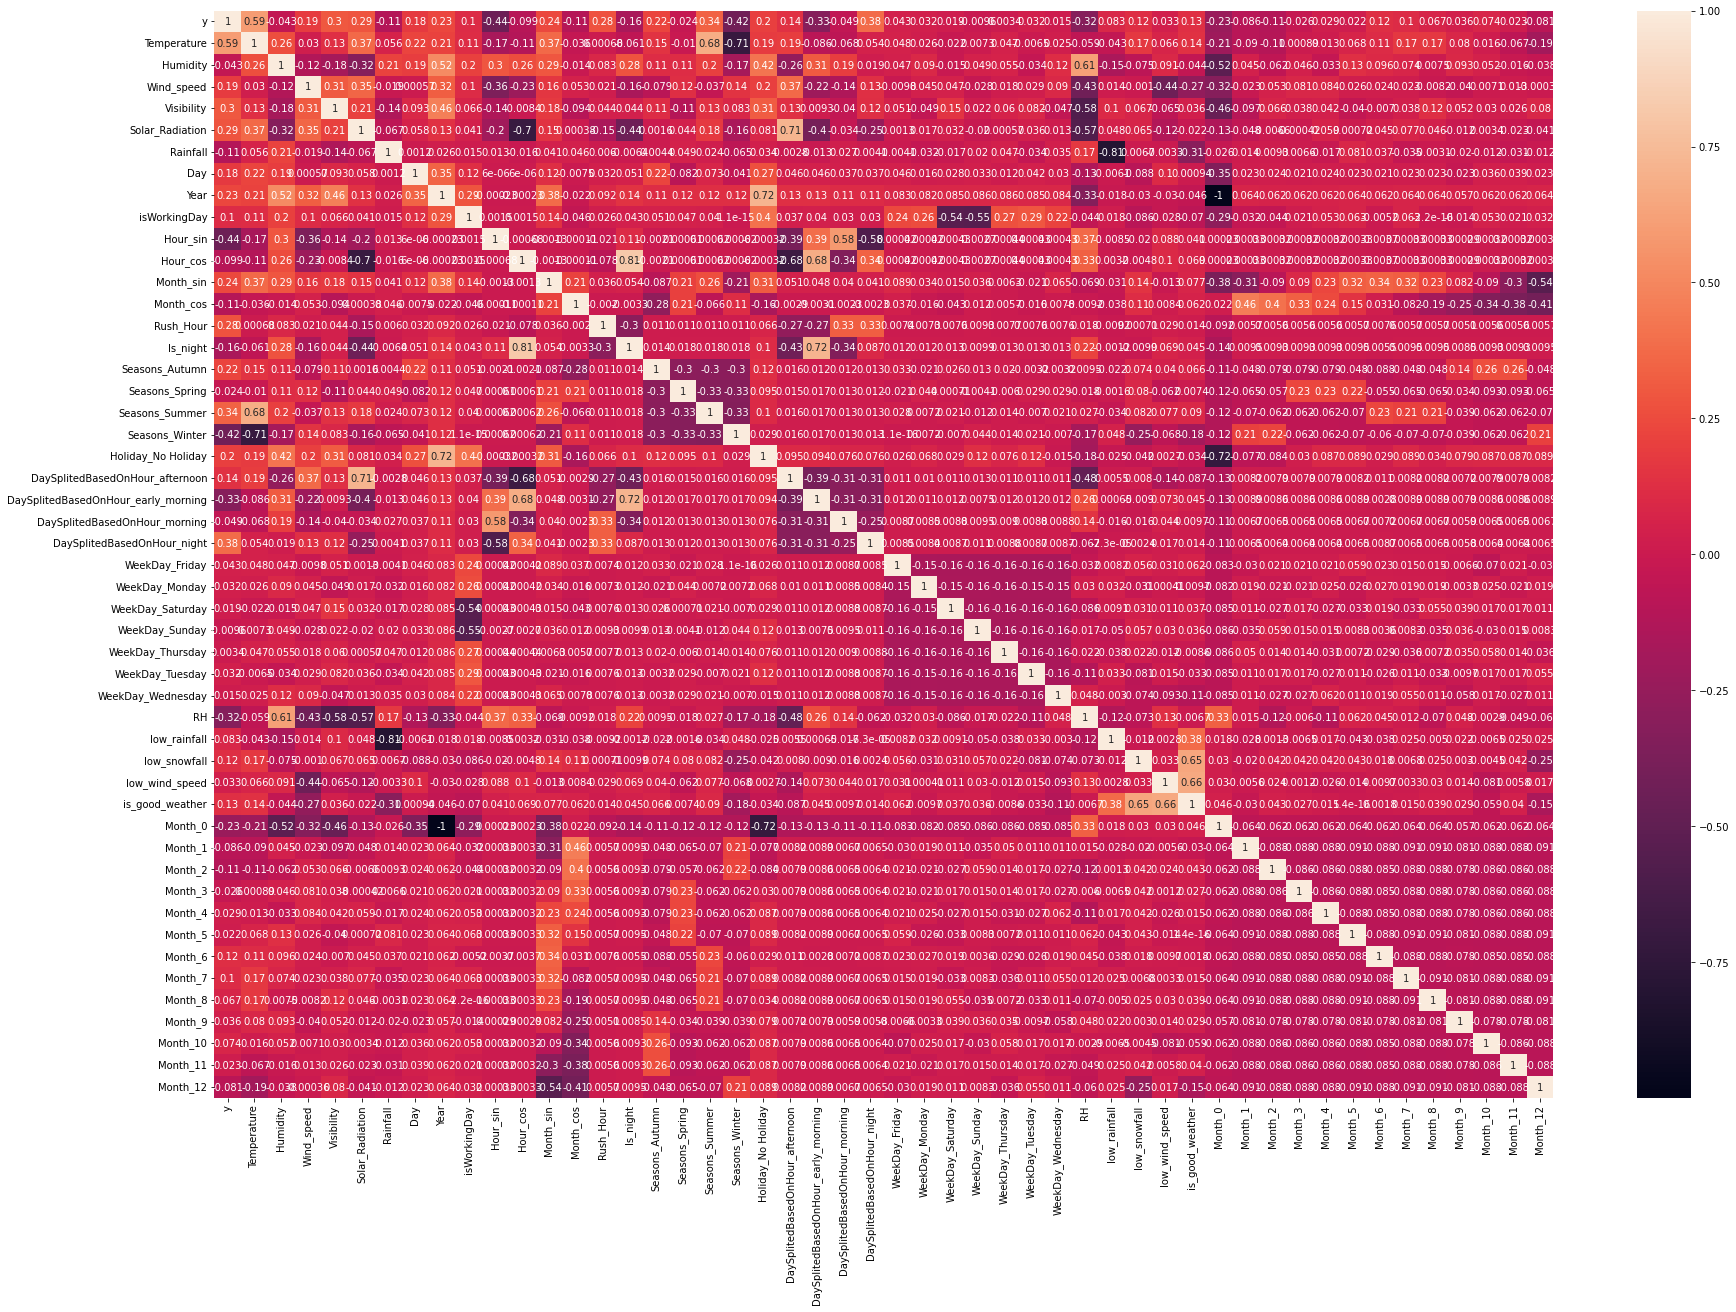

In [17]:
# Check Heatmap for all the features
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [18]:
X = df.drop('y', axis=1)
y = np.sqrt(df['y'])
# poly = PolynomialFeatures(1, interaction_only=True, include_bias=True)
# X = poly.fit_transform(X)

x_train, x_val, y_train, y_val = train_test_split(X, y,test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
# x_train = X
# y_train = y

(4608, 49)
(4608,)
(1152, 49)
(1152,)


In [19]:
if 0:
    model = LinearRegression(normalize=True)
    model.fit(x_train, y_train)
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_train) 
    print('Train_Model Accuracy =', r2_score(y_train**2, y_predicted**2))
    print('Train_RMSE =', np.sqrt(mean_squared_error(y_train**2, y_predicted**2)))
    print('Train_RMSLE =', np.sqrt(mean_squared_log_error(y_train**2, y_predicted**2)))
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_val) 
    print('Val_Model Accuracy =', r2_score(y_val**2, y_predicted**2))
    print('Val_RMSE =', np.sqrt(mean_squared_error(y_val**2, y_predicted**2)))
    print('Val_RMSLE =', np.sqrt(mean_squared_log_error(y_val**2, y_predicted**2)))
    print('---------------------------------------------------------------------')

In [20]:
if 0:
    # model = CatBoostRegressor(iterations=300, learning_rate=0.061, depth=5, random_seed=465, l2_leaf_reg=7.0) #46
    # model = CatBoostRegressor(iterations=200, learning_rate=0.0665, depth=7, random_seed=465, l2_leaf_reg=8.0) #43
    # model = CatBoostRegressor(iterations=200, learning_rate=0.065, depth=6, random_seed=465, l2_leaf_reg=7.0) #45
#     model = CatBoostRegressor(max_depth=6, iterations=253, learning_rate=0.06222, reg_lambda=0, verbose=False, random_seed=465)
    model = CatBoostRegressor(n_estimators=2000, learning_rate = 0.066, random_state=465, max_depth=7, reg_lambda = 90,verbose=False)
    model.fit(x_train, y_train)
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_train) 
    print('Train_Model Accuracy =', r2_score(y_train**2, y_predicted**2))
    print('Train_RMSE =', np.sqrt(mean_squared_error(y_train**2, y_predicted**2)))
    print('Train_RMSLE =', np.sqrt(mean_squared_log_error(y_train**2, y_predicted**2)))
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_val) 
    print('Val_Model Accuracy =', r2_score(y_val**2, y_predicted**2))
    print('Val_RMSE =', np.sqrt(mean_squared_error(y_val**2, y_predicted**2)))
    print('Val_RMSLE =', np.sqrt(mean_squared_log_error(y_val**2, y_predicted**2)))
    print('---------------------------------------------------------------------')

In [21]:
if model_randomForestRegressor:
    model = RandomForestRegressor(random_state=42)
    model.fit(x_train, y_train)
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_train) 
    print('Train_Model Accuracy =', r2_score(y_train**2, y_predicted**2))
    print('Train_RMSE =', np.sqrt(mean_squared_error(y_train**2, y_predicted**2)))
    print('Train_RMSLE =', np.sqrt(mean_squared_log_error(y_train**2, y_predicted**2)))
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_val) 
    print('Val_Model Accuracy =', r2_score(y_val**2, y_predicted**2))
    print('Val_RMSE =', np.sqrt(mean_squared_error(y_val**2, y_predicted**2)))
    print('Val_RMSLE =', np.sqrt(mean_squared_log_error(y_val**2, y_predicted**2)))
    print('---------------------------------------------------------------------')

In [22]:
if 1:
    model = XGBRegressor(n_estimators=200, learning_rate = 0.05679, random_state=465, max_depth=9, reg_lambda = 90)
    eval_set = [(x_train, y_train), (x_val, y_val)]
    model.fit(x_train, y_train, eval_metric="rmse", early_stopping_rounds = 5, eval_set=eval_set, verbose=False)
    results = model.evals_result()
    print('---------------------------------------------------------------------')
    plt.plot(range(len(results['validation_0']['rmse'])), results['validation_0']['rmse'])
    plt.plot(range(len(results['validation_1']['rmse'])), results['validation_1']['rmse'])
    plt.legend(['Train Error', 'Val Error'])
    plt.show()
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_train) 
    y_predicted[y_predicted<0] = 0
    print('Train_Model Accuracy =', r2_score(y_train**2, y_predicted**2))
    print('Train_RMSE =', np.sqrt(mean_squared_error(y_train**2, y_predicted**2)))
    print('Train_RMSLE =', np.sqrt(mean_squared_log_error(y_train**2, y_predicted**2)))
    print('---------------------------------------------------------------------')
    y_predicted = model.predict(x_val) 
    y_predicted[y_predicted<0] = 0
    print('Val_Model Accuracy =', r2_score(y_val**2, y_predicted**2))
    print('Val_RMSE =', np.sqrt(mean_squared_error(y_val**2, y_predicted**2)))
    print('Val_RMSLE =', np.sqrt(mean_squared_log_error(y_val**2, y_predicted**2)))
    print('---------------------------------------------------------------------')